<a href="https://colab.research.google.com/github/MRdvan/CNN_Segmentation_Training/blob/master/cityscapes_2class_segmentation_pytorch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Subset
import torch.backends.cudnn as cudnn
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import albumentations as A
from albumentations.pytorch import ToTensorV2
import matplotlib.pyplot as plt
import torch.nn.functional as F
import os
from PIL import Image
from torch.utils.data import Dataset

cudnn.benchmark = True
plt.ion() 

In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [ ]:
device

device(type='cpu')

In [ ]:
!nvidia-smi

Wed Sep 21 13:37:31 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   56C    P8    10W /  70W |      3MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

#train test split

In [ ]:
#!apt-get install rar
#!unrar x "/content/drive/MyDrive/cityscapes_dataset/gamma_crop_dataset/concat_mask/people_vehicle_data.rar" "/content/drive/MyDrive/cityscapes_dataset/gamma_crop_dataset/"

In [ ]:
!pip install split-folders
import splitfolders
splitfolders.ratio('/content/drive/MyDrive/cityscapes_dataset/gamma_crop_dataset/concat_mask', output="/content/drive/MyDrive/cityscapes_dataset/gamma_crop_dataset/output_2class_mask", seed=1337, ratio=(.8, .2))

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


Copying files: 6950 files [00:58, 118.16 files/s]


In [ ]:
#len(os.listdir("/content/drive/MyDrive/gamma_crop_dataset/output_img/val/images"))

1390

#load dataset

In [ ]:
width=height=520 # image width and height

In [ ]:
class CityScapesDataset(Dataset):
    def __init__(self, image_dir, mask_dir, transform=None):
        self.image_dir = image_dir
        self.mask_dir = mask_dir
        self.transform = transform
        self.images = os.listdir(image_dir)
        self.masks = os.listdir(mask_dir)
        self.images.sort()#sıralama
        self.masks.sort()#sıralama
    def __len__(self):
        return len(self.images)

    def __getitem__(self, index):
        img_path = os.path.join(self.image_dir, self.images[index])
        mask_path = os.path.join(self.mask_dir, self.masks[index])
        image = np.array(Image.open(img_path).convert("RGB"))#görüntü yükleme
        mask = np.array(Image.open(mask_path).convert("L"), dtype=np.int16)#maske yükleme
        # yalnızca araba ve insan maskelerini filtreleme
        new_mask = np.zeros((400,400))
        new_mask[mask == 101] = 1
        new_mask[mask == 109] = 1
        new_mask[mask ==93] = 2
        mask = new_mask
        del new_mask
        if self.transform is not None:
            augmentations = self.transform(image=image, mask=mask)
            #veri arttırımı
            image = augmentations["image"]
            mask = augmentations["mask"]
            targets_extend=mask.clone()
            targets_extend.unsqueeze_(0) # convert to Nx1xHxW 
            mask = torch.stack([targets_extend==i+1 for i in range(2)], dim=0).sum(dim=1)
        return image, mask

In [ ]:
#----------------------------Transform image-------------------------------------------------------

train_transform = A.Compose(
        [
            A.Resize(height=height, width=width),
            #A.Rotate(limit=35, p=1.0),
            #A.HorizontalFlip(p=0.5),
            #A.VerticalFlip(p=0.1),
            A.Normalize(
                mean=[0.0, 0.0, 0.0],
                std=[1.0, 1.0, 1.0],
            ),
            ToTensorV2(),
        ],
    )

val_transforms = A.Compose(
    [
        A.Resize(height=height, width=width),
        A.Normalize(
            mean=[0.0, 0.0, 0.0],
            std=[1.0, 1.0, 1.0],
        ),
        ToTensorV2(),
    ],
)





In [ ]:
#-------------------------------LOAD DATASET--------------------------------------

def get_loaders(train_dir,train_maskdir,val_dir,val_maskdir,batch_size,train_transform,val_transform,num_workers=2,pin_memory=True):
  
    train_ds = CityScapesDataset(image_dir=train_dir, mask_dir=train_maskdir, transform=train_transform)
    train_loader = torch.utils.data.DataLoader(train_ds,batch_size=batch_size,num_workers=num_workers,pin_memory=pin_memory, shuffle=True)
    val_ds = CityScapesDataset(image_dir=val_dir, mask_dir=val_maskdir,transform=val_transform)
    val_loader = torch.utils.data.DataLoader(val_ds,batch_size=batch_size, num_workers=num_workers,pin_memory=pin_memory, shuffle=False)

    return train_loader, val_loader

TRAIN_IMG_DIR = '/content/drive/MyDrive/gamma_crop_dataset/output_img/train/images'
TRAIN_MASK_DIR= '/content/drive/MyDrive/gamma_crop_dataset/output_mask/train/mask'
VAL_IMG_DIR= '/content/drive/MyDrive/gamma_crop_dataset/output_img/val/images'
VAL_MASK_DIR = '/content/drive/MyDrive/gamma_crop_dataset/output_mask/val/mask'
BATCH_SIZE = 8

train_dataloader, val_dataloader = get_loaders(TRAIN_IMG_DIR,TRAIN_MASK_DIR,VAL_IMG_DIR,VAL_MASK_DIR,BATCH_SIZE,train_transform,val_transforms,2,True,)

In [ ]:
img,mask = next(iter(train_dataloader))

In [ ]:
mask.dtype

torch.int64

In [ ]:
mask.shape

torch.Size([8, 2, 520, 520])

#Loss training

In [ ]:
inp1 = mask
inp2 = mask*0.9
out1 = inp1.permute(0, 2,3, 1).contiguous().view(-1, inp1.size(1))
out2 = inp2.permute(0, 2,3, 1).contiguous().view(-1, inp2.size(1))
print(out1.shape)
print(out2.shape)

torch.Size([196608, 3])
torch.Size([196608, 3])


In [ ]:
loss = nn.CrossEntropyLoss()
out1 = out1.type(torch.FloatTensor)
out2 = out2.type(torch.FloatTensor)

In [ ]:
out2.dtype

torch.float32

In [ ]:
loss(out1,out2)

tensor(0.4963)

#Visualization

In [ ]:
np.unique(mask[0,:])

array([0., 1., 2.])

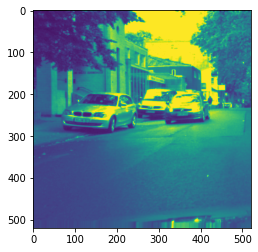

In [ ]:
plt.imshow(img[0,0,:])

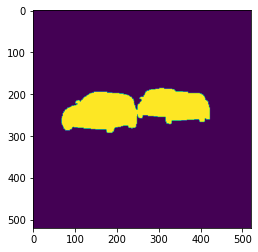

In [ ]:
plt.imshow(mask[0,0])

In [ ]:
x = mask[0][None,:]

In [ ]:
y = torch.stack([x==i for i in range(x.max()+1)], dim=0).sum(dim=1)

In [ ]:
x[0].max()

tensor(400, dtype=torch.int32)

In [ ]:
y.shape

torch.Size([401, 400, 400])

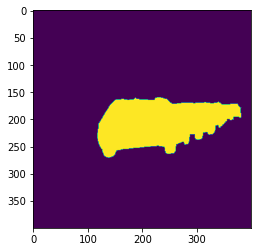

In [ ]:
plt.imshow(y[2])

In [ ]:
#os.listdir("/content/drive/MyDrive/cityscapes_dataset/gamma_crop_dataset/output_mask/train/mask")

#UNET architecture

In [ ]:
import torch
import torch.nn as nn
import torchvision.transforms.functional as TF

class DoubleConv(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(DoubleConv, self).__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, 3, 1, 1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, 3, 1, 1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
        )

    def forward(self, x):
        return self.conv(x)

class UNET(nn.Module):
    def __init__(self, in_channels=3, out_channels=2, features=[64, 128, 256, 512],):
        super(UNET, self).__init__()
        self.ups = nn.ModuleList()
        self.downs = nn.ModuleList()
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        # ENCODER KISMI
        for feature in features:
            self.downs.append(DoubleConv(in_channels, feature))
            in_channels = feature
        # DECODER KISMI
        for feature in reversed(features):
            self.ups.append(nn.ConvTranspose2d(feature*2, feature, kernel_size=2, stride=2))
            self.ups.append(DoubleConv(feature*2, feature))
        # DARBOĞAZ KISMI
        self.bottleneck = DoubleConv(features[-1], features[-1]*2)
        self.final_conv = nn.Conv2d(features[0], out_channels, kernel_size=1)

    def forward(self, x):
        skip_connections = []
        for down in self.downs:
            x = down(x)
            skip_connections.append(x)
            x = self.pool(x)

        x = self.bottleneck(x)
        skip_connections = skip_connections[::-1]

        for idx in range(0, len(self.ups), 2):
            x = self.ups[idx](x)
            skip_connection = skip_connections[idx//2]

            if x.shape != skip_connection.shape:
                x = TF.resize(x, size=skip_connection.shape[2:])

            concat_skip = torch.cat((skip_connection, x), dim=1)
            x = self.ups[idx+1](concat_skip)

        return self.final_conv(x)

#model architecture

In [ ]:
from tqdm import tqdm
import torch.optim as optim
from torchvision.models.segmentation import fcn_resnet50, FCN_ResNet50_Weights 

In [ ]:
weights = FCN_ResNet50_Weights.DEFAULT
model = fcn_resnet50(weights=weights)
model.classifier[4] = nn.Conv2d(512, 2, kernel_size=(1, 1), stride=(1, 1))
model.aux_classifier[4] = nn.Conv2d(256, 2, kernel_size=(1, 1), stride=(1, 1))
model

FCN(
  (backbone): IntermediateLayerGetter(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (downsample): Sequenti

In [ ]:
model.classifier[4] = nn.Conv2d(512, 2, kernel_size=(1, 1), stride=(1, 1))
model.aux_classifier[4] = nn.Conv2d(256, 2, kernel_size=(1, 1), stride=(1, 1))


In [ ]:
img,mask = next(iter(train_dataloader))

#Pretrain evalation

In [ ]:
model =model.eval()
pred = model(img)
sem_class_to_idx = {cls: idx for (idx, cls) in enumerate(weights.meta["categories"])}

normalized_masks = torch.nn.functional.softmax(pred["out"], dim=1)

person_car_mask = [
    normalized_masks[img_idx, sem_class_to_idx[cls]]
    for img_idx in range(len(img))
    for cls in (['car'])
]

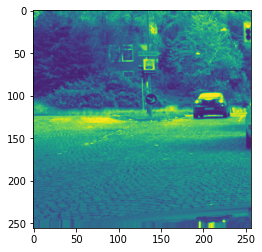

In [ ]:
plt.imshow(img[1][0])

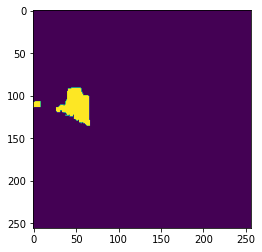

In [ ]:
plt.imshow(mask[1][2])

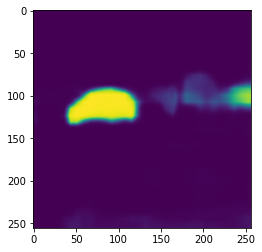

In [ ]:
# use the created array to output your multiple images. In this case I have stacked 4 images vertically
plt.imshow(person_car_mask[3].detach().numpy())

#Freeze first 3 block layers

In [ ]:
for layers in model.backbone.layer1.modules():
   for param in layers.parameters():
       param.requires_grad=False

for layers in model.backbone.layer2.modules():
   for param in layers.parameters():
       param.requires_grad=False

for layers in model.backbone.layer3.modules():
   for param in layers.parameters():
       param.requires_grad=False

In [ ]:
for layers in model.children():
  for param in layers.parameters():
    if param.requires_grad == True:
      print(param.shape)

torch.Size([64, 3, 7, 7])
torch.Size([64])
torch.Size([64])
torch.Size([512, 1024, 1, 1])
torch.Size([512])
torch.Size([512])
torch.Size([512, 512, 3, 3])
torch.Size([512])
torch.Size([512])
torch.Size([2048, 512, 1, 1])
torch.Size([2048])
torch.Size([2048])
torch.Size([2048, 1024, 1, 1])
torch.Size([2048])
torch.Size([2048])
torch.Size([512, 2048, 1, 1])
torch.Size([512])
torch.Size([512])
torch.Size([512, 512, 3, 3])
torch.Size([512])
torch.Size([512])
torch.Size([2048, 512, 1, 1])
torch.Size([2048])
torch.Size([2048])
torch.Size([512, 2048, 1, 1])
torch.Size([512])
torch.Size([512])
torch.Size([512, 512, 3, 3])
torch.Size([512])
torch.Size([512])
torch.Size([2048, 512, 1, 1])
torch.Size([2048])
torch.Size([2048])
torch.Size([512, 2048, 3, 3])
torch.Size([512])
torch.Size([512])
torch.Size([2, 512, 1, 1])
torch.Size([2])
torch.Size([256, 1024, 3, 3])
torch.Size([256])
torch.Size([256])
torch.Size([2, 256, 1, 1])
torch.Size([2])


#TRAINING

In [ ]:
from tqdm import tqdm
import torch.optim as optim
model=model.to(device) # pass model to gpu device
optimizer=torch.optim.Adam(params=model.parameters(),lr=5e-4) # Adam optimizer



In [ ]:
def save_checkpoint(state, filename="my_checkpoint.pth.tar"):
    print("=> Saving checkpoint")
    torch.save(state, filename)

def load_checkpoint(checkpoint, model):
    print("=> Loading checkpoint")
    model.load_state_dict(checkpoint["state_dict"])

def dice_metric(inputs, target):
    intersection = 2.0 * (target * inputs).sum()
    union = target.sum() + inputs.sum()
    if target.sum() == 0 and inputs.sum() == 0:
        return 1.0

    return intersection / union

def dice_loss(inputs, target):
    num = target.size(0)
    inputs = inputs.reshape(num, -1)
    target = target.reshape(num, -1)
    smooth = 1.0
    intersection = (inputs * target)
    dice = (2. * intersection.sum(1) + smooth) / (inputs.sum(1) + target.sum(1) + smooth)
    dice = 1 - dice.sum() / num
    return dice

def dice_loss_simple(inputs,target):
  return 1-dice_metric(inputs,target)


In [ ]:
#import segmentation_models_pytorch as smp
#Linknet
#FPN
#PSPNet
"""model = smp.Unet(
    encoder_name="resnet34",        # choose encoder, e.g. mobilenet_v2 or efficientnet-b7
    encoder_weights="imagenet",     # use `imagenet` pre-trained weights for encoder initialization
    in_channels=3,                  # model input channels (1 for gray-scale images, 3 for RGB, etc.)
    classes=2,                      # model output channels (number of classes in your dataset)
    activation = "softmax"
).to(device)"""


'model = smp.Unet(\n    encoder_name="resnet34",        # choose encoder, e.g. mobilenet_v2 or efficientnet-b7\n    encoder_weights="imagenet",     # use `imagenet` pre-trained weights for encoder initialization\n    in_channels=3,                  # model input channels (1 for gray-scale images, 3 for RGB, etc.)\n    classes=2,                      # model output channels (number of classes in your dataset)\n    activation = "softmax"\n).to(device)'

In [ ]:
model.load_state_dict(torch.load("/content/drive/MyDrive/cityscapes_with_unet_pytorch/my_checkpoint_unet.pth"))

<All keys matched successfully>

In [ ]:
def check_accuracy(loader, model, device="cuda"):
    num_correct_car = 0
    num_correct_person = 0
    num_pixels_car = 0
    num_pixels_person = 0
    dice_score = 0
    dice_score_car =0
    dice_score_person = 0
    model.eval()
    with torch.no_grad():
        for x, y in tqdm(loader):
            x = x.to(device)
            y = y.to(device)
            preprocess = weights.transforms()
            batch = preprocess(x)
            preds = model(batch)["out"]
            preds_car = (preds[0] > 0.5).float()
            preds_person = (preds[1] > 0.5).float()
            num_correct_car += (preds_car == y[0]).sum()
            num_correct_person += (preds_person == y[1]).sum()
            num_pixels_car += torch.numel(preds_car)
            num_pixels_person += torch.numel(preds_person)
            dice_score_car += dice_metric(preds_car,y[0])
            dice_score_car += dice_metric(preds_person,y[1])
            dice_score=(dice_score_car+dice_score_person)/2

    print(
        f"Got {num_correct_car}/{num_pixels_car} with acc {num_correct_car/num_pixels_car*100:.2f}"
    )
    print(
        f"Got {num_correct_person}/{num_pixels_person} with acc {num_correct_person/num_pixels_person*100:.2f}"
    )
    print(f"Dice score: {dice_score/len(loader)}")
    model.train()

    def convert_target_pred(pred,target):
    pred = pred.permute(0, 2,3, 1).contiguous().view(-1, pred.size(1))
    target = target.permute(0, 2,3, 1).contiguous().view(-1, target.size(1))
    pred = pred.type(torch.cuda.FloatTensor)
    target = target.type(torch.cuda.FloatTensor)
    return pred,target

In [ ]:
NUM_EPOCHS = 30

In [ ]:
for epoch in range(NUM_EPOCHS):
    running_loss = 0
    for x, y in tqdm(train_dataloader):
        model.train()  # put model to training mode
        x = x.to(device=device)  # move to device, e.g. GPU
        y = y.to(device=device)

        with torch.cuda.amp.autocast():
            pred = model(x)["out"]
            normal_pred = pred.softmax(dim=1)
            loss= dice_loss(normal_pred,y)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        running_loss += loss
    print('train_loss =' + str(running_loss/len(train_dataloader)))

    with torch.no_grad():
        acc=0
        for x, y in tqdm(val_dataloader):
            x = x.to(device)
            y = y.to(device)
            #preprocess = weights.transforms()
            #batch = preprocess(x)
            preds = model(x)["out"]
            acc+=dice_metric(preds,y)
    print('dicecoef =' + str(acc*100/len(val_dataloader)))
    torch.save(model.state_dict(), "/content/drive/MyDrive/cityscapes_with_pytorch/my_checkpoint_fcn.pth")


100%|██████████| 1390/1390 [30:04<00:00,  1.30s/it]


train_loss =tensor(0.8721, device='cuda:0', grad_fn=<DivBackward0>)


100%|██████████| 1390/1390 [01:47<00:00, 12.97it/s]


train_loss =tensor(1.7439, device='cuda:0', grad_fn=<DivBackward0>)


100%|██████████| 1390/1390 [01:49<00:00, 12.72it/s]


train_loss =tensor(2.6157, device='cuda:0', grad_fn=<DivBackward0>)


100%|██████████| 1390/1390 [01:47<00:00, 12.96it/s]


train_loss =tensor(3.4876, device='cuda:0', grad_fn=<DivBackward0>)


100%|██████████| 1390/1390 [01:45<00:00, 13.13it/s]


train_loss =tensor(4.3594, device='cuda:0', grad_fn=<DivBackward0>)


100%|██████████| 1390/1390 [01:46<00:00, 13.10it/s]


train_loss =tensor(5.2312, device='cuda:0', grad_fn=<DivBackward0>)


100%|██████████| 1390/1390 [01:45<00:00, 13.17it/s]


train_loss =tensor(6.1029, device='cuda:0', grad_fn=<DivBackward0>)


100%|██████████| 1390/1390 [01:45<00:00, 13.22it/s]


train_loss =tensor(6.9747, device='cuda:0', grad_fn=<DivBackward0>)


100%|██████████| 1390/1390 [01:45<00:00, 13.17it/s]


train_loss =tensor(7.8465, device='cuda:0', grad_fn=<DivBackward0>)


100%|██████████| 1390/1390 [01:45<00:00, 13.19it/s]


train_loss =tensor(8.7182, device='cuda:0', grad_fn=<DivBackward0>)


100%|██████████| 1390/1390 [01:45<00:00, 13.23it/s]


train_loss =tensor(9.5899, device='cuda:0', grad_fn=<DivBackward0>)


100%|██████████| 1390/1390 [01:45<00:00, 13.20it/s]


train_loss =tensor(10.4615, device='cuda:0', grad_fn=<DivBackward0>)


100%|██████████| 1390/1390 [01:45<00:00, 13.20it/s]


train_loss =tensor(11.3333, device='cuda:0', grad_fn=<DivBackward0>)


100%|██████████| 1390/1390 [01:45<00:00, 13.21it/s]


train_loss =tensor(12.2049, device='cuda:0', grad_fn=<DivBackward0>)


100%|██████████| 1390/1390 [01:46<00:00, 13.11it/s]


train_loss =tensor(13.0766, device='cuda:0', grad_fn=<DivBackward0>)


100%|██████████| 1390/1390 [02:04<00:00, 11.16it/s]


train_loss =tensor(13.9482, device='cuda:0', grad_fn=<DivBackward0>)


100%|██████████| 1390/1390 [01:50<00:00, 12.59it/s]


train_loss =tensor(14.8199, device='cuda:0', grad_fn=<DivBackward0>)


100%|██████████| 1390/1390 [01:48<00:00, 12.76it/s]


train_loss =tensor(15.6915, device='cuda:0', grad_fn=<DivBackward0>)


100%|██████████| 1390/1390 [01:50<00:00, 12.60it/s]


train_loss =tensor(16.5630, device='cuda:0', grad_fn=<DivBackward0>)


100%|██████████| 1390/1390 [01:50<00:00, 12.62it/s]


train_loss =tensor(17.4346, device='cuda:0', grad_fn=<DivBackward0>)


100%|██████████| 1390/1390 [01:50<00:00, 12.54it/s]


train_loss =tensor(18.3063, device='cuda:0', grad_fn=<DivBackward0>)


100%|██████████| 1390/1390 [01:52<00:00, 12.40it/s]


train_loss =tensor(19.1779, device='cuda:0', grad_fn=<DivBackward0>)


100%|██████████| 1390/1390 [01:51<00:00, 12.47it/s]


train_loss =tensor(20.0494, device='cuda:0', grad_fn=<DivBackward0>)


100%|██████████| 1390/1390 [01:51<00:00, 12.43it/s]


train_loss =tensor(20.9209, device='cuda:0', grad_fn=<DivBackward0>)


100%|██████████| 1390/1390 [01:52<00:00, 12.36it/s]


train_loss =tensor(21.7924, device='cuda:0', grad_fn=<DivBackward0>)


100%|██████████| 1390/1390 [01:52<00:00, 12.37it/s]


train_loss =tensor(22.6639, device='cuda:0', grad_fn=<DivBackward0>)


100%|██████████| 1390/1390 [01:53<00:00, 12.28it/s]


train_loss =tensor(23.5355, device='cuda:0', grad_fn=<DivBackward0>)


100%|██████████| 1390/1390 [01:54<00:00, 12.15it/s]


train_loss =tensor(24.4070, device='cuda:0', grad_fn=<DivBackward0>)


100%|██████████| 1390/1390 [01:58<00:00, 11.74it/s]


train_loss =tensor(25.2785, device='cuda:0', grad_fn=<DivBackward0>)


100%|██████████| 1390/1390 [03:19<00:00,  6.96it/s]


train_loss =tensor(26.1501, device='cuda:0', grad_fn=<DivBackward0>)


100%|██████████| 174/174 [06:48<00:00,  2.35s/it]

dicecoef =tensor(-3.3221, device='cuda:0')


In [ ]:
model.load_state_dict(torch.load("/content/drive/MyDrive/cityscapes_with_unet_pytorch/my_checkpoint.pth"))

RuntimeError: ignored

In [ ]:
model.eval()
for i,(img,mask) in enumerate(val_dataloader):
  if i == 9:
    image = img
    maske = mask 
    break

In [ ]:
image=image.to(device)
maske=maske.to(device)
predict = model(image)["out"]
predict = predict.softmax(dim=1)
#predict,maske = convert_target_pred(predict,maske)
acc=dice_metric(predict[0,0],maske[0,0])
acc_1=dice_metric(predict[0,1],maske[0,1])
loss=dice_loss_simple(predict[0,0],maske[0,0])
loss_1=dice_loss_simple(predict[0,1],maske[0,1])
print(loss)
print(acc)
print(acc_1)
print(loss_1)

tensor(0.7509, device='cuda:0', grad_fn=<RsubBackward1>)
tensor(0.2491, device='cuda:0', grad_fn=<DivBackward0>)
tensor(0.0124, device='cuda:0', grad_fn=<DivBackward0>)
tensor(0.9876, device='cuda:0', grad_fn=<RsubBackward1>)


In [ ]:
maske.shape

torch.Size([2, 2, 256, 256])

In [ ]:
tensor(0.7709, device='cuda:0', grad_fn=<RsubBackward1>)
tensor(0.2291, device='cuda:0', grad_fn=<DivBackward0>)
tensor(0.0018, device='cuda:0', grad_fn=<DivBackward0>)
tensor(0.9982, device='cuda:0', grad_fn=<RsubBackward1>)

In [ ]:
tensor(0.8119, device='cuda:0', grad_fn=<RsubBackward1>)
tensor(0.1881, device='cuda:0', grad_fn=<DivBackward0>)
tensor(0.2742, device='cuda:0', grad_fn=<DivBackward0>)
tensor(0.7258, device='cuda:0', grad_fn=<RsubBackward1>)

torch.Size([1, 2, 520, 520])

In [ ]:
predict.shape

torch.Size([8, 2, 256, 256])

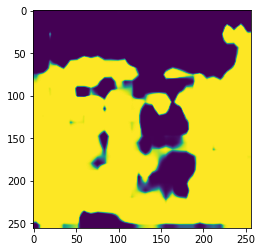

In [ ]:
plt.imshow(predict[3,0].cpu().detach().numpy())

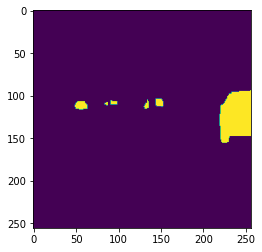

In [ ]:
plt.imshow(maske[3,0].cpu().detach().numpy())

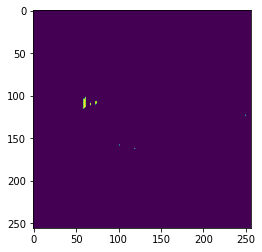

In [ ]:
plt.imshow(maske[1,1].cpu().detach().numpy())

In [ ]:
from torchvision.io import read_image
from pathlib import Path

image = read_image(str(Path('/content/drive/MyDrive/gamma_crop_dataset/output_img/train/images') / 'image43.png'))
mask = read_image(str(Path('/content/drive/MyDrive/gamma_crop_dataset/output_mask/train/mask') / 'mask43.png'))

In [ ]:
image = np.array(Image.open("/content/drive/MyDrive/gamma_crop_dataset/output_img/train/images/image35.png").convert("RGB"))
mask = np.array(Image.open("/content/drive/MyDrive/gamma_crop_dataset/output_mask/train/mask/mask35.png").convert("L"), dtype=np.int16)

In [ ]:
img,mask = next(iter(train_dataloader))

In [ ]:
image.shape

torch.Size([3, 400, 400])

In [ ]:
model.eval() #modeli eval moduna alma
preprocess = weights.transforms()
batch = preprocess(image).unsqueeze(0) #ön işleme
prediction = model(batch)["out"] #tahmin alımı
normalized_masks = prediction.softmax(dim=1) #tahminlerin kesinleştirilmesi
class_to_idx = {cls: idx for (idx, cls) in enumerate(weights.meta["categories"])} #istenilen sınıfların filtrelenmesi
mask = normalized_masks[0, class_to_idx[["car","person"]]] #

In [ ]:
car_mask_clone = car_mask.clone

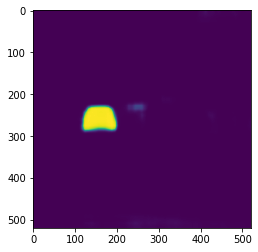

In [ ]:
plt.imshow(car_mask.detach().numpy())

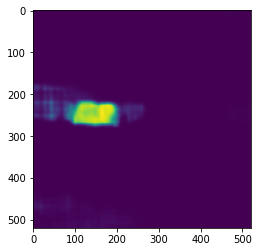

In [ ]:
plt.imshow(car_mask.detach().numpy())

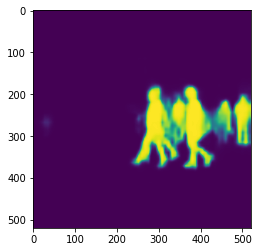

In [ ]:
plt.imshow(person_mask.detach().numpy())

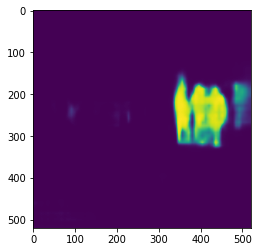

In [ ]:
plt.imshow(person_mask.detach().numpy())

In [ ]:
pred_mask = 0

In [ ]:
total_mask = person_mask.detach().numpy()*2 + car_mask.detach().numpy()

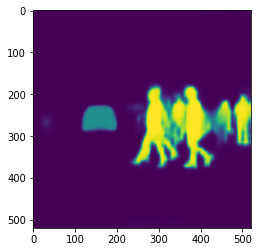

In [ ]:
plt.imshow(total_mask)

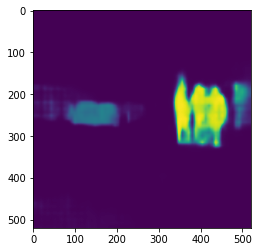

In [ ]:
plt.imshow(pred_mask)

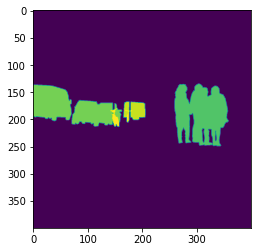

In [ ]:
plt.imshow(mask[0].detach().numpy())